<a href="https://colab.research.google.com/github/Alton01/ml-vtm-pytorch-ciphar10/blob/main/cifar_10VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.6.0+cu124'

In [3]:
torchvision.__version__

'0.21.0+cu124'

In [4]:
## 2. setup device agnostic code

In [5]:
torch.cuda.is_available()

True

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
print(f"Using Device: {device}")

Using Device: cuda


In [8]:
## 3. Set the seed

In [9]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

In [10]:
3e-4

0.0003

In [11]:
## 4. Setting the hyperparameters

In [12]:
BATCH_SIZE = 128
EPOCHS = 10 # try increasing epochs to 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32 # transform image and make imagesize go to 224
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8 #  try increasing number of heads
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

In [13]:
## 5.Define image transformations operation

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
    #helps the model to converge faster
    # helps to make the numerical computation stable
])

#transform_train = transforms.Compose([
 #   transforms.RandomCrop(32, padding=4),
 #   transforms.RandomHorizontalFlip(),
  #  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
  #  transforms.ToTensor(),
  #  transforms.Normalize((0.5), (0.5))
    #helps the model to converge fasterand helps model perform better
    # helps to make the numerical computation stable
#])

In [19]:
## 6. Getting a dataset

In [20]:
train_dataset = datasets.CIFAR10(root="data",
                                 train=True,
                                 download=True,
                                 transform=transform)

100%|██████████| 170M/170M [00:04<00:00, 36.2MB/s]


In [21]:
test_dataset = datasets.CIFAR10(root="data",
                                train=False,
                                download=True,
                                transform=transform)

In [22]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [23]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [24]:
## step 7 converting our datasets into dataloaders
## This means breaking dataset into batches or minibatches
## Computationally efficient ascomputing hardware may not handle 50,000 images
## At a go
## so we break it into 128 images at a time (BATCH_SIZE = 128)
## It gives our neural network more chances to update its gradient per epoch

In [25]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

In [26]:
## Lets check out what we have created
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7bdf33a60fd0>, <torch.utils.data.dataloader.DataLoader object at 0x7bdf437d1ad0>)
Length of train_loader: 391 batches of 128...
Length of test_loader: 79 batches of 128...


In [27]:
## 8. Building Vision Transformer model from scratch.
#Splitting each image into smaller bits(patches)

In [28]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               img_size,
               patch_size,
               in_channels,
               embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels=in_channels,
                          out_channels=embed_dim,
                          kernel_size=patch_size,
                          stride=patch_size)
    num_patches = (img_size // patch_size) ** 2
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x)
    x = x.flatten(2).transpose(1, 2)
    cls_tokens = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + self.pos_embed
    return x


In [29]:
## Define multi layer perceptron class

In [30]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features=in_features,
                         out_features=hidden_features)
    self.fc2 = nn.Linear(in_features=hidden_features,
                         out_features=in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x

In [31]:
## Building a transformer encoder layer

In [32]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self, x):
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

In [33]:
## create a vision transformer class to combine all of these components

In [34]:
class VisionTransformer(nn.Module):
  def __init__ (self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.encoder = nn.Sequential(*[
        TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
        for _ in range(depth)
    ])
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    return self.head(cls_token)

In [35]:
## create an instance from our vision transformer class/ instantiate model

In [36]:
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [37]:
##9 Define a loss function and optimizer

In [38]:
criterion = nn.CrossEntropyLoss() #used when classifying into muliple classes. measures how wrong our model is
optimizer = torch.optim.Adam(params=model.parameters(), # updates our model parameters to try and reduce the loss
                             lr=LEARNING_RATE)

In [39]:
criterion

CrossEntropyLoss()

In [40]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [41]:
# Create function to train our model
# Defining a training loop function

In [42]:
device

'cuda'

In [43]:
def train(model, loader, optimizer, criterion):
  model.train()

  total_loss, correct = 0, 0

  for x, y in loader:
    #moving/sending data into target device
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    #1 forward pass(model outputs raw logits)
    out = model(x)
    #2 calculate the loss per batch
    loss = criterion(out, y)
    #3 Perform back propagation to compute the gradient of the loss with respect to our parameters.
    loss.backward()
    #4 perform gradient descent algorithm
    optimizer.step()

    total_loss += loss.item() * x.size(0)
    correct += (out.argmax(1) == y).sum().item()
    # you have to scale the loss(normalization step to make the loss general across all batches)
  return total_loss / len(loader.dataset), correct / len(loader.dataset)


In [ ]:
# defining evaluate function

In [44]:
def evaluate(model, loader):
  model.eval() #eval sets the mode of the model into evaluation
  correct = 0
  with torch.inference_mode():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      out = model(x)
      correct += (out.argmax(dim=1) == y).sum().item()
  return correct / len(loader.dataset)

In [45]:
EPOCHS

10

In [46]:
from tqdm.auto import tqdm

In [ ]:
## training the model

In [47]:
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch: {epoch + 1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train loss: 1.7331, Train acc: 0.3708%, Test acc: 0.4770
Epoch: 2/10, Train loss: 1.3834, Train acc: 0.5039%, Test acc: 0.5328
Epoch: 3/10, Train loss: 1.2328, Train acc: 0.5584%, Test acc: 0.5723
Epoch: 4/10, Train loss: 1.1271, Train acc: 0.5967%, Test acc: 0.5822
Epoch: 5/10, Train loss: 1.0379, Train acc: 0.6279%, Test acc: 0.6069
Epoch: 6/10, Train loss: 0.9662, Train acc: 0.6542%, Test acc: 0.6187
Epoch: 7/10, Train loss: 0.8885, Train acc: 0.6824%, Test acc: 0.6242
Epoch: 8/10, Train loss: 0.8157, Train acc: 0.7079%, Test acc: 0.6134
Epoch: 9/10, Train loss: 0.7457, Train acc: 0.7352%, Test acc: 0.6314
Epoch: 10/10, Train loss: 0.6707, Train acc: 0.7621%, Test acc: 0.6319


In [48]:
train_accuracies

[0.37082,
 0.50392,
 0.55842,
 0.59672,
 0.62786,
 0.65416,
 0.68238,
 0.70788,
 0.73518,
 0.76212]

In [ ]:
test_accuracies

[]

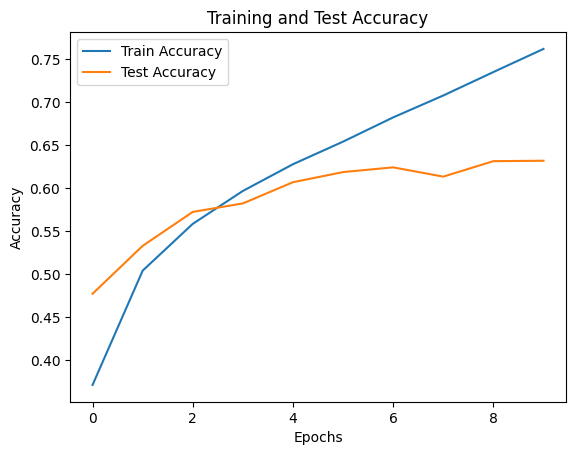

In [49]:
#plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [50]:
import random

In [51]:
len(train_dataset)

50000

In [54]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
  model.eval()
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0, len(dataset) -1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output.data, 1)
      img = img / 2 + 0.5 #unnormalize our images to be able to plot them with matplotlib
      npimg = img.cpu().numpy()
      axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = "g"
      else:
        color = "r"

      axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
      axes[i, j].axis("off")
  plt.tight_layout()
  plt.show()